In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

In [5]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
sf_pv_df = pd.read_csv(data_location + "energy/SF_PV.csv")

df = sf_pv_df.copy(deep=True)
df["I"] = np.append(0, sf_pv_df["y"].values[1:] - sf_pv_df["y"].values[:-1])

## Shared weights without hidden Layers

In [6]:
m = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3 * 24,
    n_forecasts=24,
    learning_rate=0.01,
    early_stopping=False,
    shared_weights=True,
)
m = m.add_lagged_regressor("I", n_lags=24, normalize="standardize")
df_train, df_test = m.split_df(df, freq="H", valid_p=0.10)

metrics = m.fit(df_train, freq="H", validation_df=df_test, progress="plot")

ERROR - (NP.config.__post_init__) - Invalid growth for global_local mode 'local'. Set to 'global'
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ metrics_train │ MetricCollection │      0 │
│ 1 │ metrics_val   │ MetricCollection │      0 │
│ 2 │ ar_net        │ ModuleList       │  1.7 K │
│ 3 │ covar_nets    │ ModuleDict       │    576 │
│ 4 │ shared_net    │ ModuleList       │  2.3 K │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 4.6 K                                                                      
Non-trainable params: 0                                                                      
Total params: 4.6 K                                                                          
Total estimated model params size (MB): 0

Output()

In [7]:
metrics.tail(1)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
11,36.198307,54.045692,0.001877,0.0,11,57.62875,96.684174,0.0045,0.0


<BarContainer object of 72 artists>

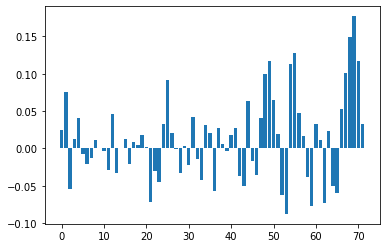

In [8]:
ar_weights = m.model.state_dict()["shared_net.0.weight"][0][:72]
plt.bar(range(len(ar_weights)), ar_weights)

<BarContainer object of 24 artists>

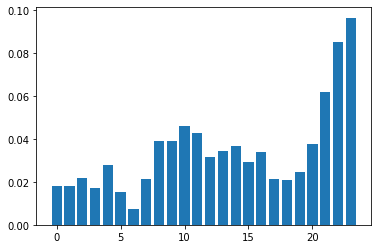

In [9]:
covar_weights = m.model.state_dict()["shared_net.0.weight"][0][-24:]
plt.bar(range(len(covar_weights)), covar_weights)

## Shared weights with hidden Layers

ERROR - (NP.config.__post_init__) - Invalid growth for global_local mode 'local'. Set to 'global'
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ metrics_train │ MetricCollection │      0 │
│ 1 │ metrics_val   │ MetricCollection │      0 │
│ 2 │ ar_net        │ ModuleList       │    808 │
│ 3 │ covar_nets    │ ModuleDict       │    808 │
│ 4 │ shared_net    │ ModuleList       │  1.4 K │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 3.0 K                                                                      
Non-trainable params: 0                                                                      
Total params: 3.0 K                                                                          
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=109` reached.


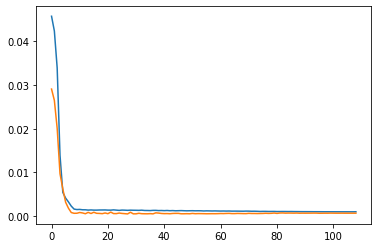

In [52]:
m = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3 * 24,
    num_hidden_layers=4,
    d_hidden=8,
    learning_rate=0.003,
    early_stopping=False,
    shared_weights=True,
)

df_train, df_test = m.split_df(df, freq="H", valid_p=0.10)
m = m.add_lagged_regressor("I", normalize="standardize")
metrics = m.fit(df_train, freq="H", validation_df=df_test, progress="plot")

In [53]:
metrics.tail(1)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
108,13.820248,31.869785,0.000653,0.0,108,21.061636,42.177887,0.000982,0.0


In [47]:
m.model.shared_net

ModuleList(
  (0): Linear(in_features=96, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=8, bias=True)
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): Linear(in_features=8, out_features=8, bias=True)
  (4): Linear(in_features=8, out_features=24, bias=False)
)

In [62]:
import torch
import torch.nn as nn
from captum.attr import IntegratedGradients

class InterpretableModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, layer_input):
        return self.model.shared_layer(layer_input)

model = InterpretableModel(m.model)

# defining model input tensors
model_input = torch.ones([m.model.shared_net[0].in_features], requires_grad=True).unsqueeze(0)

# defining baselines for each input tensor
baseline = torch.zeros([m.model.shared_net[0].in_features], requires_grad=True).unsqueeze(0)

target = 0

ig = IntegratedGradients(model)
attributions, approximation_error = ig.attribute(model_input,
                                                 target=target,
                                                 baselines=baseline,
                                                 method='gausslegendre',
                                                 return_convergence_delta=True)

<BarContainer object of 72 artists>

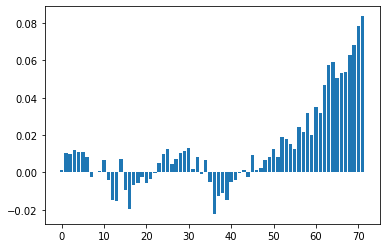

In [63]:
ar_attrs = attributions.squeeze(0).detach().numpy()[:72]
plt.bar(range(len(ar_attrs)), ar_attrs)

<BarContainer object of 72 artists>

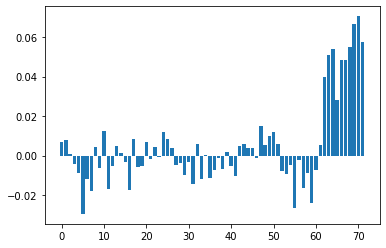

In [60]:
covar_attrs = attributions.squeeze(0).detach().numpy()[-72:]
plt.bar(range(len(covar_attrs)), covar_attrs)